## Data Preparation:
    Data Preparation is the first step to be performed with the data. This process consists of collecting, cleaning, transforming, and manipulating raw data to make it usable for analysis. 

In [2]:
import pandas as pd
import os
import plotly.express as px
import matplotlib as plt

import warnings

warnings.filterwarnings("ignore")

# Dublin Bikes datasets:
    These datasets were collected from data.gov.ie and they are under License: Creative Commons Attribution 4.0 (CC BY 4.0)
    As a total de 12 file were downloaded, this code will read all files and concatenate into a data frame called dublin_hist.


In [3]:
path = "./"
files = [file for file in os.listdir(path) if file.startswith('dublinbike-historical-data-2023') ] # filter only historical data files

dublin_hist = pd.DataFrame()

# for loop will load the file in a dataframe "current_month" and concatenate it to the dataframe "dublin_hist".
for file in files:
    current_month = pd.read_csv(path+"/"+file)
    dublin_hist = pd.concat([dublin_hist, current_month])

dublin_hist.shape

(1852356, 11)

### Extracting Station Name and Location for a new dataframe: dublin_bike_stations
    From the dataset, the bike stations will be extracted buy removing duplicates stations from all hist also, unicessary columns will be removed

In [4]:
dublin_bike_stations = dublin_hist[['STATION ID','NAME','BIKE_STANDS','STATUS','LATITUDE', 'LONGITUDE']].drop_duplicates(subset=["STATION ID"])

dublin_bike_stations.head()

,STATION ID,NAME,BIKE_STANDS,STATUS,LATITUDE,LONGITUDE
0,1,CLARENDON ROW,31,OPEN,53.3409,-6.26250
1,2,BLESSINGTON STREET,20,OPEN,53.3568,-6.26814
2,3,BOLTON STREET,20,OPEN,53.3512,-6.26986
3,4,GREEK STREET,20,OPEN,53.3469,-6.27298
4,5,CHARLEMONT PLACE,40,OPEN,53.3307,-6.26018


### For proper analysis, only historical data and open station_id will be selected.


In [5]:
# Filtering only OPEN stations and rename columns.
dublin_hist = dublin_hist[dublin_hist['STATUS'] == 'OPEN']

dublin_hist = dublin_hist[['STATION ID', 'TIME', 'BIKE_STANDS', 'AVAILABLE_BIKE_STANDS', 'AVAILABLE_BIKES']]

#rename column AVAILABLE_BIKE_STANDS to BIKES_IN_USE
dublin_hist.rename(columns={'AVAILABLE_BIKE_STANDS': 'BIKES_IN_USE'}, inplace=True)


# Setting the TIME collumn to datetime
dublin_hist['TIME'] = pd.to_datetime(dublin_hist['TIME'])
dublin_hist.head()

,STATION ID,TIME,BIKE_STANDS,BIKES_IN_USE,AVAILABLE_BIKES
0,1,2023-01-01 00:00:03,31,31,0
1,2,2023-01-01 00:00:03,20,18,2
2,3,2023-01-01 00:00:03,20,9,11
3,4,2023-01-01 00:00:03,20,8,12
4,5,2023-01-01 00:00:03,40,16,24


# Calculating the number of trips 

    to get the number of  trips, its is necessary to create a for loop, to filter the dataframe by STATION ID and compare the number of BIKES_IN_USE from current row, to the previous row (diff),  if the number of BIKES_IN_USE is  bigger the previous row, so its a new trip otherwise not

In [6]:
# create a empty dataframe to receive the cleaned result
bike_usage = pd.DataFrame()

for i in dublin_bike_stations['STATION ID']:
    # filter by STATION ID 
    fitered = dublin_hist[dublin_hist['STATION ID']== i]

    # Sorting by time
    fitered = fitered.sort_values(by=['TIME'], ascending=True)
    
    # creating a new collumn, "TRIPS" and getting the diff of each row
    fitered["TRIPS"] = fitered["BIKES_IN_USE"].diff()
    
    # Concatenat the new bike_usage dataframe with the filtered dataframe (only with trips)
    bike_usage = pd.concat([bike_usage, fitered[fitered['TRIPS']>0]])



bike_usage.head()

,STATION ID,TIME,BIKE_STANDS,BIKES_IN_USE,AVAILABLE_BIKES,TRIPS
1921,1,2023-01-01 08:30:03,31,31,0,1.0
2938,1,2023-01-01 13:00:02,31,29,2,1.0
3390,1,2023-01-01 15:00:03,31,29,2,1.0
3616,1,2023-01-01 16:00:02,31,29,2,1.0
3842,1,2023-01-01 17:00:03,31,30,1,1.0


# Dublin Bikes Reviews
    For collection of Dublin Bikes Reviews, a tripadvisor API was created and stored in a .env file
    For collection of Dublin Bikes Reviews through API, the IP address of the client must be specified in tripadvisor development platform.
    Also, a Webscraping was performed on Yelp.com website.
    * Yelp's Terms of Service specifically forbid scraping their website for commercial purposes. However, they do allow scraping for personal, non-commercial and research purposes. 

In [ ]:
from dotenv import load_dotenv
from os import getenv
load_dotenv()
import requests
import json

# Setting Parameters
api_key = getenv('API_KEY')   
location_id = "6439815"   # Dublin Bikes id in TripAdvisor.

url = f"https://api.tripadvisor.com/api/partner/2.0/location/{location_id}/reviews"

headers = {
    "Content-Type": "application/json",
    "X-TripAdvisor-API-Key": api_key, 
}


# This code makes a GET request, If the status code is 200 (Sucess), then it extracts the JSON data from the response and converts it into a pandas DataFrame. 
# If the status code is not 200, then it prints an error message

response = requests.get(url, headers=headers)

if response.status_code == 200:
    
    data = response.json()
    dublin_reviews_df = pd.DataFrame( data['data'])
       
else:
    print(f"Error: {response.status_code}")
    print(response.text)

#print the dataframe:
dublin_reviews_df

    The API request was successful, but analysing the results and the documentation from TripAdvisor, the API return onle the las 5 reviews, which were note a significant population to perfor Machine Learning Research.
    Due this result and , a WebScraper Code was generated to scrap reviews from Yelp.

In [ ]:
import requests
from bs4 import BeautifulSoup 

url_list = 'https://www.yelp.ie/biz/capital-bikeshare-washington?osq=capital+bikeshare'
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"}

# The function getinfo retrieves reviews and their corresponding titles and ratings from  tripadvisor URL.
# it uses BeautifulSoup to scrape the website and stores the extracted data in a Pandas DataFrame.
# Args: url (str): The URL of the website containing the reviews to be extracted.
# Returns:  review_df (DataFrame): A Pandas DataFrame containing the title, reviews and ratings.

#def getinfo(url):     
        

response = requests.get(url_list)
soup = BeautifulSoup(response.content, 'html.parser')
#yelpreview_df = pd.DataFrame()
        

In [ ]:
soup

In [ ]:
review = soup.find_all('span', attrs={'class': 'raw__09f24__T4Ezm'})
    #review_lst = []
      #  for title in titles:
       #      title_lst.append(title.find('span', attrs={'class': 'raw__09f24__T4Ezm'}).text)
        
        
       # reviews = soup.find_all('span', attrs={'class':'JguWG'})

        #review_list = []
        #for review in reviews:
        #        review_list.append(review.find('span', attrs={'class': 'yCeTE'}).text)
                
       # rate = soup.find_all('svg', attrs={'class':'UctUV d H0'})
       # rate_list = []
       # for r in rate:
       #         rate_list.append(r.get('aria-label'))
        
        #yelpreview_df['title'] = pd.DataFrame(title_lst)
        #review_df['review'] = pd.DataFrame(review_list)
        #review_df['rate'] = pd.DataFrame(rate_list)
review   
        
#return yelpreview_df

In [ ]:
# this code will call the function "getinfo" for each url in the list "url_list"
# it will wait for 15 seconds between each call to the function "getinfo" to avoid overloading the server and getting no response.
error = False
import time
all_reviews_df = pd.DataFrame()
for url in url_list:
    time.sleep(15)
    try:
        all_reviews_df = pd.concat([all_reviews_df, getinfo(url)])    
    except Exception:
        print('Error to scrap url:', url)
        error = True

all_reviews_df

#all_reviews_df['rate'] = all_reviews_df['rate'].str.slice(0,3)

# Capital BikeShare Dataset
    These datasets were collected from: https://ride.capitalbikeshare.com/system-data and they are under "Capital Bikeshare Data License Agreement"
    As a total de 12 file were downloaded, this code will read all files and concatenate into a data frame called capital_df.



In [ ]:
capital_df

In [ ]:

path = "./"
files = [file for file in os.listdir(path) if file.endswith('capitalbikeshare-tripdata.csv') ] # filter only historical data files

capital_df = pd.DataFrame()

# for loop will load the file in a dataframe "current_month" and concatenate it to the dataframe "capital_df".
for file in files:
    current_month = pd.read_csv(path+"/"+file)
    capital_df = pd.concat([capital_df, current_month])

capital_df.shape

### Extracting the Bike Station  location

In [ ]:
capital_stations = capital_df[['start_station_id','start_station_name','start_lat','start_lng']].drop_duplicates(subset=["start_station_id"])


# rename the columns name
col_names = {'start_station_id': 'station_id', 'start_station_name': 'station_name', 'start_lat': 'lat','start_lng':'long'}
capital_stations.rename(columns=col_names, inplace=True)
capital_stations.head()



# Cleaning Capital_df dataset

In [ ]:
capital_df.head()

In [ ]:
# Find out if is there any duplicated row and null value

print('duplicated rides:' ,capital_df['ride_id'].duplicated().sum())
print('Null Values: \n',capital_df.isnull().sum())

    Not duplicated rides, but there are some Station_id with null values. Its necessary to fix it


In [ ]:
null_rows = capital_df[capital_df.isnull().any(axis=1)]


In [ ]:
null_rows.head()

In [ ]:
display(capital_df.shape)
display(capital_df_reg.sort_values(by='start_station_id', ascending = False).head())

In [ ]:
import numpy as np

capital_sample = capital_df_reg.sample(796540)
capital_sample.shape


Applying Linear Regression did not get a good result. The R-squared value of 0.270 is relatively low, which means that the model is not explaining much of the variation in the data, also, the mean squared error is 0.059, its high and that means, the model is making errors.

In [ ]:
X_test

In [ ]:
# confirm that splitting also has similar distribution 
print(y_train.mean())
print(y_test.mean())

In [ ]:
# Scale features
X_scaled = scaler.fit_transform(X)

# Choose a distance metric
metric = 'euclidean'  # Other options are 'manhattan' and 'cosine'

# Choose a value for k
k = 5 

# Create a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
# Train the k-NN classifier
knn.fit(X_scaled, y)


predictions = knn.predict(X_test)
print(predictions)

In [ ]:
accuracy_score(y_test, predictions)

In [ ]:
# Evaluate the model on a separate test set
from sklearn.metrics import accuracy_score

# Load test data
test_data = pd.read_csv('test.csv')

# Separate features and target
X_test = test_data[['rideable_type']]
y_test = test_data['start_station_id']

# Scale test features
X_test_scaled = scaler.transform(X_test)

# Make predictions on test data
y_pred = knn.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

In [ ]:
capital_df_reg.head()

In [ ]:
#Correlation
import numpy as np
import seaborn as sns
# Calculate correlation matrix

#sns.heatmap(capital_df_reg.corr())
capital_df_reg.corr()



In [ ]:
import seaborn as sns

sns.heatmap(correlation_matrix)

    For this dataset, each row represents one trip, and threre are other rows differente from dublin Bike, as the purpose is to compare both sistems, this dataset will be cleaned to became similar to dublin bikeshare dataset.
    As, the purpose of this project is compare the quantity of riders,  these null values will be replaced by 'uknown station'

In [ ]:
capital_df = capital_df[['start_station_id','started_at']]


# each row represents one trip
capital_df['TRIPS']=1


In [ ]:
capital_df['start_station_id'].fillna('Unknown Station', inplace=True)


In [ ]:
capital_df.info()

In [ ]:
# Set the right  type format of column

capital_df['started_at'] = pd.to_datetime(capital_df['started_at'])


# EDA (Exploratory Data Analysis)  - Understanding the data and patterns

In [ ]:
Skewness:

In [ ]:
capital_df.head(1)

In [ ]:
import plotly.express as px

fig = px.histogram(capital_df, x="started_at", y="TRIPS",  marginal="rug",
                   hover_data=capital_df.columns)
fig.show()

In [ ]:
capital_df
# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plot the distributions on the subplots
sns.distplot(capital_df['started_at'], ax=axes[0, 0])
sns.distplot(capital_df['TRIPS'], ax=axes[0, 1])

# Tighten the layout of the subplots
plt.tight_layout()

plt.show()

In [ ]:
# BoxPlot

In [ ]:

import plotly.express as px

fig = px.box(capital_df)
fig.show()



In [ ]:
import plotly.express as px
color_mapper = {"OPEN": "#7CFC00", "CLOSED": "#DF0030"}

fig = px.scatter_mapbox(dublin_bike_stations, 
                        lat="LATITUDE",
                        lon="LONGITUDE", 
                        color="STATUS", 
                        size="BIKE_STANDS", 
                        color_discrete_map=color_mapper,
                        size_max=15, 
                        zoom=12, 
                        hover_data=["BIKE_STANDS"],
                        mapbox_style="open-street-map")

# Update layout for larger figure size
fig.update_layout(
    title="Bike Stations in Dublin",
    autosize=False,
    width=1200, 
    height=600,  
)
fig.show()

In [ ]:
import plotly.express as px


fig = px.scatter_mapbox(capital_stations, 
                        lat="lat",
                        lon="long", 
                        size_max=15, 
                        zoom=12, 
                        hover_data=["station_name"],
                        mapbox_style="open-street-map")

# Update layout for larger figure size
fig.update_layout(
    title="Bike Stations  - Washington DC",
    autosize=False,
    width=1200, 
    height=600,  
)
fig.show()

# Number of trips by weekday and By month - comparing both datasets
The best approach to perform these chart, is using a dinamic apresentation, and for this purpose, a dashboart using dash and plotly was created

In [ ]:
 # Prepare Weekday dataset
        capital_df['WEEKDAY'] = capital_df['started_at'].dt.weekday
        df_weekady = capital_df.groupby(['WEEKDAY']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('WEEKDAY', ascending=True)
        # reneame the weedkday using a mpa 
        df_weekady['WEEKDAY'] = df_weekady['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
        
        # Create Plots
        fig = px.bar(df_weekady, x='WEEKDAY', y='TRIPS', 
                     labels=dict(x='WEEKDAY', y='TRIPS'),
                     title='Bike Usage by Weekday',
                     width = 600, height = 500)

In [ ]:

        # Prepare Weekday dataset
        bike_usage['WEEKDAY'] = bike_usage['TIME'].dt.weekday
        df_weekady = bike_usage.groupby(['WEEKDAY']).agg(BIKE_STANDS=('BIKE_STANDS', 'sum'), 
                                         TRIPS=('TRIPS', 'sum')).reset_index().sort_values('WEEKDAY', ascending=True)
        # reneame the weedkday using a mpa 
        df_weekady['WEEKDAY'] = df_weekady['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
        
        # Create Plots
        fig = px.bar(df_weekady, x='WEEKDAY', y='TRIPS', 
                     labels=dict(x='WEEKDAY', y='TRIPS'),
                     title='Bike Usage by Weekday',
                     width = 600, height = 500)
        

In [ ]:
# Import libraries for Dash 
import dash
from dash import html
from dash import dcc
from datetime import datetime
from dash.dependencies import Input, Output

# Create app Dash
app = dash.Dash(__name__)

# Create a list of option for the dropdown
Location_options = ['Dublin', 'Washington DC',]

# create a app layout
app.layout = html.Div([
    html.H1("Bike Usage by Weekday and Month"),
    dcc.Graph(id='graph'),

    # Create dropdown for selecting time period
    html.Label(["Location:",
               dcc.Dropdown(
                 id='location-dropdown',
                 options=[
                     {'label': category, 'value': category} for category in Location_options
                 ],
                 value='Dublin',
                 clearable=False,
               ),
    ]),
])

# Define callback to update graph based on selected time period
@app.callback(
    Output('graph', 'figure'),
    [Input('location-dropdown', 'value')]
)

# Function update_graph creates a chart based on the selection (selected_time)
def update_graph(Location_options):
    if Location_options == 'Dublin':
        
        fig = Location_options
    else:  # if Washington DC  was selected
        fig = Location_options

                
        return fig

# Run the app
app.run_server(mode='inline')


In [ ]:
capital_df['WEEKDAY'] = capital_df['started_at'].dt.weekday
capital_df


In [ ]:
'''      
df_weekady = capital_df.groupby(['WEEKDAY']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('WEEKDAY', ascending=True)
        # reneame the weedkday using a mpa 
        df_weekady['WEEKDAY'] = df_weekady['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
        
        # Create Plots
        fig = px.bar(df_weekady, x='WEEKDAY', y='TRIPS', 
                     labels=dict(x='WEEKDAY', y='TRIPS'),
                     title='Bike Usage by Weekday',
                     width = 600, height = 500)
'''       

In [ ]:
bike_usage

In [ ]:

        
'''
        
        # Prepare Monty Dataset
        bike_usage['MONTH'] = bike_usage['TIME'].dt.month
        df_month = bike_usage.groupby(['MONTH']).agg(BIKE_STANDS=('BIKE_STANDS', 'sum'), 
                                         TRIPS=('TRIPS', 'sum')).reset_index().sort_values('MONTH', ascending=True)

        df_month['MONTH'] = df_month['MONTH'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

        
        
        # Create a line chart of bike usage
        #fig2 = px.bar(df_month, x='MONTH', y='TRIPS', 
                    #labels=dict(x='MONTH', y='TRIPS'),
                    #title='Bike Usage by MONTH', 
                    #width = 600, height = 500)
  
        # Combine plots into subplots
        
        #make_subplots(rows=1, cols=2)
        #fig.add_trace(fig1, row=1, col=1)
        #fig.add_trace(fig2, row=1, col=2)
        #fig.show()
'''

# 2.0 Statistics for Data Analytics
### Descriptive statistics are a set of tools and techniques used to summarize and describe the key features of a dataset.

In [ ]:
bike_usage['MONTH'] = bike_usage['TIME'].dt.month
bike_usage['WEEKDAY'] = bike_usage['TIME'].dt.weekday
bike_usage


# Distribution and Density

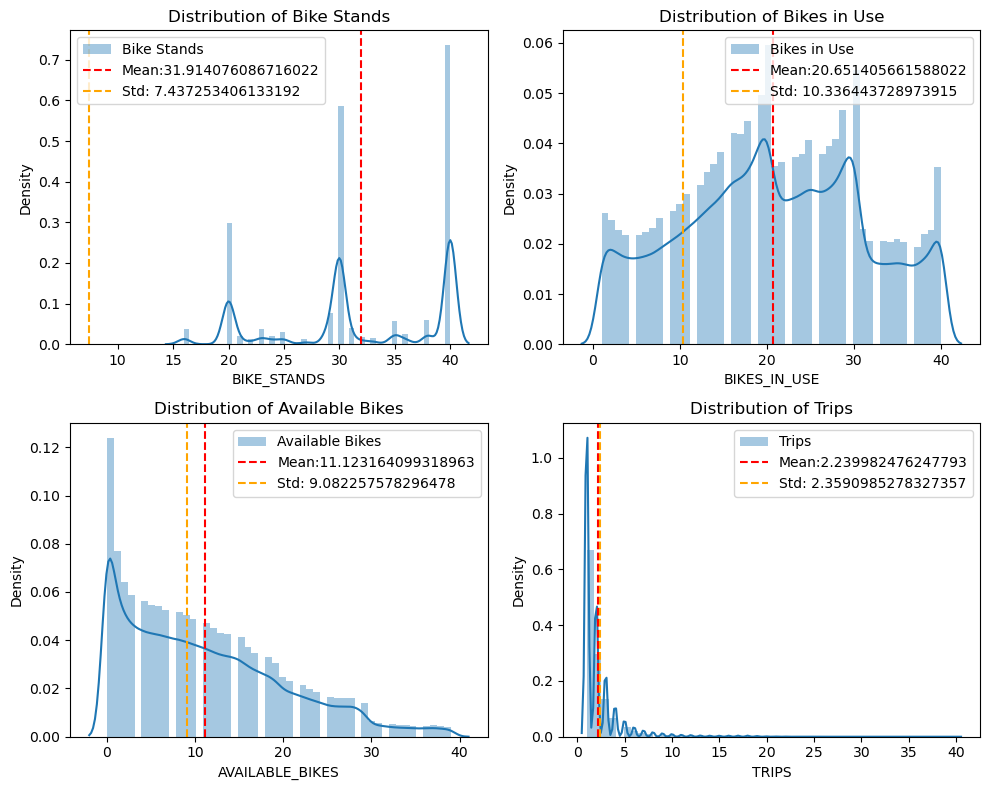

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot the distributions on the subplots

std_dev = bike_usage["BIKE_STANDS"].std()
mean = bike_usage['BIKE_STANDS'].mean()
sns.distplot(bike_usage['BIKE_STANDS'], ax=axes[0, 0], label='Bike Stands')
axes[0, 0].set_title('Distribution of Bike Stands')
axes[0, 0].axvline(bike_usage['BIKE_STANDS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0, 0].axvline(bike_usage['BIKE_STANDS'].std(), color='orange', linestyle='--', label= (f'Std: {std_dev}'))
axes[0, 0].legend()



std_dev = bike_usage["BIKES_IN_USE"].std()
mean = bike_usage['BIKES_IN_USE'].mean()                 
sns.distplot(bike_usage['BIKES_IN_USE'], kde=True, ax=axes[0, 1], label='Bikes in Use')
axes[0, 1].set_title('Distribution of Bikes in Use')
axes[0, 1].axvline(bike_usage['BIKES_IN_USE'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0, 1].axvline(bike_usage['BIKES_IN_USE'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[0, 1].legend()




std_dev = bike_usage["AVAILABLE_BIKES"].std()
mean = bike_usage['AVAILABLE_BIKES'].mean()
sns.distplot(bike_usage['AVAILABLE_BIKES'], kde=True, ax=axes[1, 0], label='Available Bikes')
axes[1, 0].set_title('Distribution of Available Bikes')
axes[1, 0].axvline(bike_usage['AVAILABLE_BIKES'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1, 0].axvline(bike_usage['AVAILABLE_BIKES'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1, 0].legend()




std_dev = bike_usage["TRIPS"].std()
mean = bike_usage['TRIPS'].mean()
sns.distplot(bike_usage['TRIPS'], kde=True, ax=axes[1, 1], label='Trips')
axes[1, 1].set_title('Distribution of Trips')
axes[1, 1].axvline(bike_usage['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1, 1].axvline(bike_usage['TRIPS'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1, 1].legend()

# Tighten the layout of the subplots
plt.tight_layout()

    b

# Correlation between Bike Stands and Bikes in Use


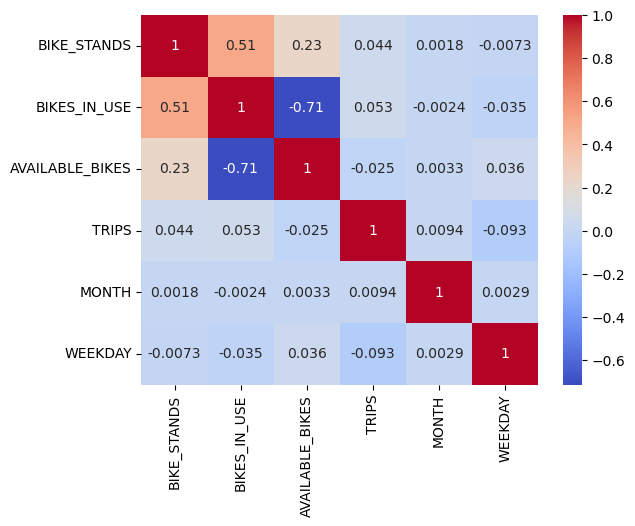

In [229]:
import seaborn as sns
# Correlation between Bike Stands and Bikes in Use
corr = bike_usage[['BIKE_STANDS', 'BIKES_IN_USE', 'AVAILABLE_BIKES', 'TRIPS', 'MONTH', 'WEEKDAY']].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")

plt.show()



# From this correlation heatmap, its possigle to observe these insights. 

    There is a strong negative correlation between BIKE_STANDS and BIKES_IN_USE. This means that as the number of bike stands at a station increases, the number of bikes in use at that station decreases. 
    There is a moderate negative correlation between AVAILABLE_BIKES and TRIPS. This means that as the number of available bikes at a station decreases, the number of bike trips starting  from station increases. 
    there is a very weak correlation between MONTH and TRIPS. This suggests that the number of bike trips does not vary significantly throughout the year.



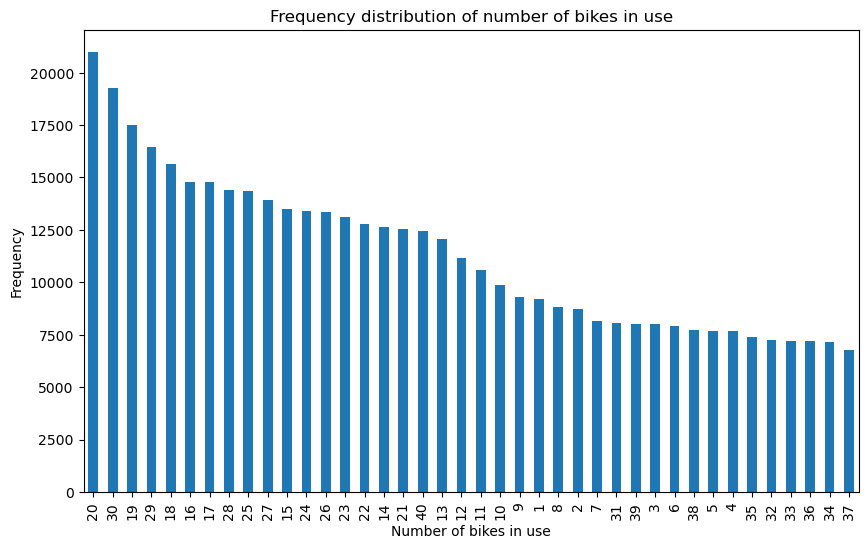

In [230]:
# Create a frequency distribution bar chart for the number of bikes in use
plt.figure(figsize=(10, 6))
bike_usage['BIKES_IN_USE'].value_counts().plot(kind='bar')
plt.xlabel('Number of bikes in use')
plt.ylabel('Frequency')
plt.title('Frequency distribution of number of bikes in use')
plt.show()

# Insights from the frequency distribution of number of bikes in use:
    Its shown that the data is skewed to the right. This means that there are more stations with a high number of bikes in use than stations with a low number of bikes in use. The most common number of bikes in use is 30, and there are a number of stations with more than 30 bikes in use

In [232]:
import pandas as pd
import matplotlib.pyplot as plt

# Adjust the output forma
pd.options.display.float_format = '{:.4f}'.format

# Calculate descriptive statistics for BIKE_STANDS and TRIPS
bike_usage[['BIKE_STANDS','BIKES_IN_USE','TRIPS']].describe()

,BIKE_STANDS,BIKES_IN_USE,TRIPS
count,451958.0000,451958.0000,451958.0000
mean,31.9141,20.6514,2.2400
std,7.4373,10.3364,2.3591
min,16.0000,1.0000,1.0000
25%,29.0000,13.0000,1.0000
50%,30.0000,20.0000,1.0000
75%,40.0000,29.0000,2.0000
max,40.0000,40.0000,40.0000


from this descriptive statistics, its observed that the minimum number of bikes in use is 1, and the maximum is 40. The median number of bikes in use is 20, meaning that half of the bike stands have 20 or fewer bikes in use, and the other half have 20 or more bikes in use.

The 25th percentile is 13, and the 75th percentile is 29. This means that the middle 50% of bike stands have between 13 and 29 bikes in use.

Overall, this data suggests that the number of bikes in use varies widely from bike stand to bike stand. However, the median and 25th/75th percentile values suggest that most bike stands have between 13 and 29 bikes in use.

In [ ]:

# Plot frequency distribution bar chart
plt.figure(figsize=(10, 6))
plt.hist(bike_usage['BIKES_IN_USE'], bins=10, edgecolor='black')
plt.xlabel('Number of bikes in use')
plt.ylabel('Frequency')
plt.title('Frequency distribution of number of bikes in use')
plt.show()

The most common number of bikes in use is 20, with over 60,000 bike stands having 20 bikes in use. The number of bike stands with a given number of bikes in use decreases as the number of bikes in use increases or decreases.

There are a few possible explanations for the shape of the frequency distribution. One possibility is that the number of bikes in use is simply a reflection of the demand for bikes at each bike stand. More popular bike stands will have more bikes in use, while less popular bike stands will have fewer bikes in use.

# Mean of the trips per month.

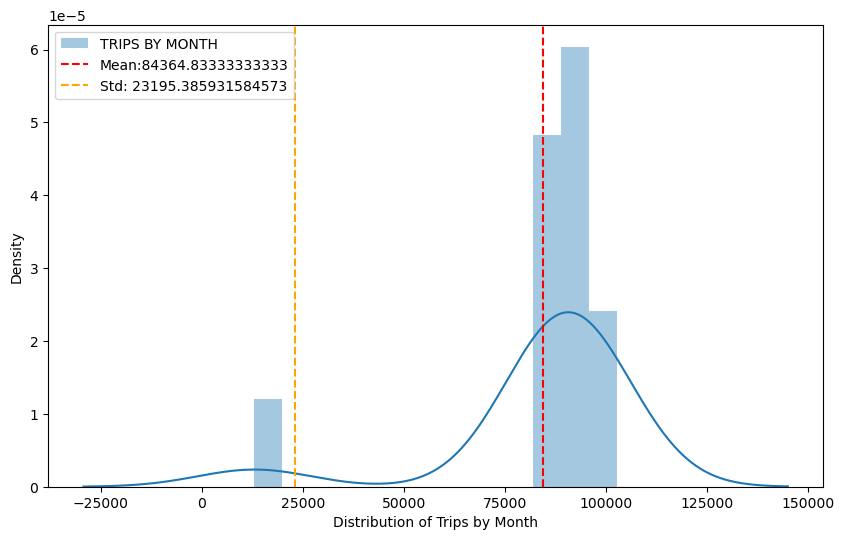

In [ ]:
df_month = bike_usage.groupby(['MONTH']).agg(BIKE_STANDS=('BIKE_STANDS', 'sum'), TRIPS=('TRIPS', 'sum')).reset_index().sort_values('MONTH', ascending=True)
df_month['MONTH'] = df_month['MONTH'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
df_month[['MONTH','TRIPS']]


plt.figure(figsize=(10, 6))
std_dev = df_month["TRIPS"].std()
mean = df_month['TRIPS'].mean()
sns.distplot(df_month['TRIPS'], kde=True, label='TRIPS BY MONTH')
plt.xlabel('Distribution of Trips by Month')
plt.axvline(df_month['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
plt.axvline(df_month['TRIPS'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
plt.legend()
plt.show()



In [237]:
import pandas as pd
import matplotlib.pyplot as plt

# Adjust the output forma
pd.options.display.float_format = '{:.4f}'.format

# Calculate descriptive statistics for BIKE_STANDS and TRIPS
bike_usage[['BIKE_STANDS','TRIPS']].describe()

,BIKE_STANDS,TRIPS
count,451958.0000,451958.0000
mean,31.9141,2.2400
std,7.4373,2.3591
min,16.0000,1.0000
25%,29.0000,1.0000
50%,30.0000,1.0000
75%,40.0000,2.0000
max,40.0000,40.0000


As you can see, the descriptive statistics for the BIKE_STANDS and TRIPS features are consistent with the findings from the visualizations. The means and medians are close to each other, but the standard deviations are relatively high, indicating that there is a lot of variability in the data. The ranges are also quite large, suggesting that there are a few stations with a very high number of bike stands and trips.

The histograms show that both the BIKE_STANDS and TRIPS features are skewed to the right. This suggests that there are a few stations with a very high number of bike stands and trips, while most stations have a smaller number. This is consistent with the idea that some stations are more popular than others, and that the demand for bikes varies throughout the day.

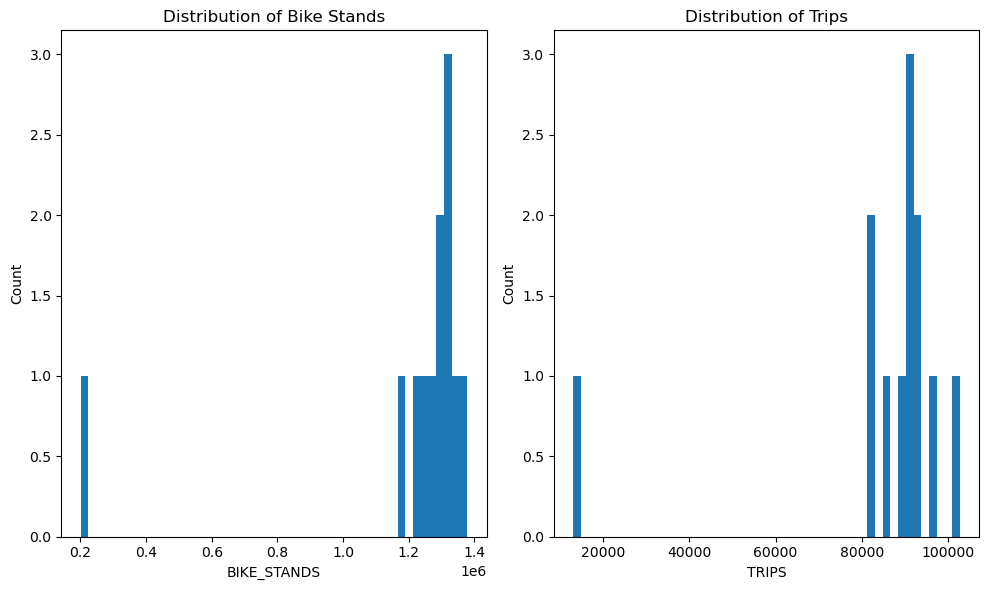

In [238]:
# Visualize the distribution of BIKE_STANDS and TRIPS using histograms
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.hist(df_month['BIKE_STANDS'], bins=50)
plt.xlabel('BIKE_STANDS')
plt.ylabel('Count')
plt.title('Distribution of Bike Stands')

plt.subplot(122)
plt.hist(df_month['TRIPS'], bins=50)
plt.xlabel('TRIPS')
plt.ylabel('Count')
plt.title('Distribution of Trips')

plt.tight_layout()
plt.show()


Central Tendency: Measures that represent the "middle" of a data distribution. These include:

Mean: The average of all the values in the data set.
Median: The middle value when all the data points are arranged in ascending order.
Mode: The most frequently occurring value in the data set.
Variability: Measures that describe how spread out the data is. These include:

Range: The difference between the largest and smallest values in the data set.
Standard Deviation: A measure of how spread out the data is around the mean.
Variance: The square of the standard deviation.